In [1]:
%matplotlib widget

import tensorflow as tf
import os
import sys
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from annoy import AnnoyIndex

In [2]:
DATASET_PATH = "/Users/jeremy/Google Drive/datasets/fashion-dataset/"
print(os.listdir(DATASET_PATH))

['embeddings.tsv', '.DS_Store', 'images.csv', 'images', 'resnet50-embeddings-full.pkl', 'styles_preprocessed.csv', 'styles', 'styles.csv', '.ipynb_checkpoints', 'embeddings.csv', 'resnet50-embeddings.pkl']


In [3]:
df = pd.read_csv(DATASET_PATH + "styles_preprocessed.csv", error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


In [4]:
def get_img_path(img):
  return DATASET_PATH + "images/" + img

In [5]:
df_embs = pickle.load(open(DATASET_PATH + "resnet50-embeddings-full.pkl", "rb"))

In [6]:
# Filter only embeddings with master category 'Apparel' and save indices to filter for them later
df_filtered = df.loc[df.masterCategory == 'Apparel']
df_filtered_idx = df_filtered.index.values.tolist()
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.masterCategory.unique(), df_filtered.shape, len(df_filtered_idx)

(array(['Apparel'], dtype=object), (21384, 11), 21384)

In [7]:
gender = ['Men', 'Women']

df_filtered_gender = df_filtered.loc[df_filtered.gender.isin(gender)]
df_filtered_gender_idx = df_filtered_gender.index.values.tolist()
df_filtered_gender = df_filtered_gender.reset_index(drop=True)
df_filtered_gender.gender.unique(), df_filtered_gender.shape, len(df_filtered_gender_idx)

(array(['Men', 'Women'], dtype=object), (19962, 11), 19962)

In [7]:
embs_filtered = []
for i, row in df_embs.iterrows():
    if i in df_filtered_idx:
        embs_filtered.append(row)
df_embs_filtered = pd.DataFrame(embs_filtered)
df_embs_filtered = df_embs_filtered.reset_index(drop=True)
df_embs_filtered

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,5.661311,2.366158,0.000000,3.255738,0.845207,2.673839,8.780884,6.280785,0.787186,1.587661,...,2.463607,0.000000,1.825991,20.485271,3.902871,0.000000,8.225970,1.313863,0.000000,10.820534
1,5.790412,9.593652,0.000000,9.431687,0.287238,0.259950,17.028755,3.037456,0.136339,0.000000,...,1.670569,0.013894,10.338679,4.784732,0.189142,0.000000,7.739138,0.372693,0.000000,8.903797
2,5.882204,1.958622,0.000000,12.519884,0.000000,0.000000,9.383584,3.781623,0.000000,1.490620,...,17.825481,0.000000,3.592513,2.042306,0.000000,0.000000,6.656784,1.457313,1.694215,1.403330
3,0.245961,17.383436,0.493822,3.374461,2.567365,0.000000,6.482548,5.862635,0.000000,3.164864,...,4.464021,0.447082,1.448132,12.884141,0.000000,0.397487,5.028076,1.939697,0.000000,11.485396
4,0.028540,18.567101,0.000000,0.757250,1.504954,0.000000,1.982043,2.963786,1.072763,4.539298,...,3.247076,4.273134,3.088639,16.997049,0.000000,0.000000,2.258092,1.595798,0.000000,7.674057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21379,2.336987,2.931590,0.340415,0.000000,5.307281,2.332621,3.968483,0.000000,1.437002,0.000000,...,0.000000,10.318655,6.127640,0.087796,5.119102,2.752746,7.465514,1.991170,9.380097,2.955148
21380,0.633122,0.000000,4.457406,0.000000,6.216387,0.042522,0.432072,10.987885,0.000000,0.000000,...,0.000000,4.146195,5.211245,1.403371,0.000000,4.482322,2.346628,3.530182,1.511959,9.264108
21381,6.349792,0.000000,4.759300,0.612483,2.310788,6.365235,3.555249,2.476688,2.579871,0.000000,...,1.343328,0.000000,9.924846,6.657773,1.471480,2.938079,8.081431,4.499643,2.201873,6.262376
21382,3.240706,3.164666,1.432326,0.000000,6.707993,2.458005,1.362674,5.246448,4.765794,0.368006,...,0.766387,0.841877,5.818806,5.233179,13.290008,4.033611,4.718810,0.000000,3.842501,2.448438


In [8]:
# Perform PCA over the embeddings to reduce dimensionality
num_feature_dimensions = 2  # Set the number of embedding dimensions
pca = PCA(n_components = num_feature_dimensions)
embs_compressed = pca.fit_transform(df_embs_filtered)
df_embs_filtered_compressed = pd.DataFrame(embs_compressed)
df_embs_filtered_compressed

,0,1
0,-88.980186,-32.450222
1,-77.086060,-38.768353
2,-60.361145,-16.859980
3,-86.249428,-26.857937
4,-77.589966,-12.887078
...,...,...
21379,76.778831,14.153075
21380,95.796707,-4.922487
21381,129.862473,-74.929871
21382,65.753059,46.186623


In [9]:
# Application of SVM to create the axis for a given feature
X = df_embs_filtered_compressed
y = df_filtered["season"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
svm_clf = LinearSVC(C=1, max_iter=10000000)
svm_clf.fit(X_scaled, y)

LinearSVC(C=1, max_iter=10000000)

In [10]:
number_of_embeddings = df_filtered.shape[0]

f = 2
t = AnnoyIndex(f, 'euclidean')
for index, row in df_embs_filtered_compressed.iterrows():
    v = row.iloc[row.index].values.tolist()
    t.add_item(index, v)

t.build(10)
#t.save('annoy_index_1000d.ann')

True

In [11]:
def get_nearest_neighbour(user_position, df):
   i = t.get_nns_by_vector(user_position, 1)
   nearest_neighbour = df.iloc[i]['id'].values[0]
   return nearest_neighbour

In [12]:
def annotate_nearest_neighbour(nearest_neighbour, df):
    arr_img = plt.imread(get_img_path(df.loc[df['id'] == nearest_neighbour].image.values[0]))
    plt.imshow(arr_img)

In [13]:
def compute_navigation_axis(emb, w, dist):
    nav_axis = []
    for i, feature in enumerate(emb):
        feature_val = emb[feature].values[0]
        step = w[i]
        axis = [feature_val]
        pos_val = feature_val
        neg_val = feature_val
        for i in range(dist):
            pos_val = pos_val + step
            neg_val = neg_val - step
            axis.append(pos_val)
            axis.append(neg_val)
        nav_axis.append(sorted(axis))
    return np.array(nav_axis)

In [14]:
def initialize_user_position(axis, idx):
    user_position = []
    for dim in axis:
        user_position.append(dim[idx])
    return user_position

In [15]:
def update_user_position(change):
    """Update the user position after the slider value has changed"""
    idx = np.where(np.isclose(nav_axis[0], min(nav_axis[0], key=lambda x:abs(x-change.new))))[0][0]
    new_user_pos = []
    for i in range(len(nav_axis)):
        new_user_pos.append(nav_axis[i][idx])
    user_position = new_user_pos
    nearest_neighbour = get_nearest_neighbour(user_position, df_filtered)
    annotate_nearest_neighbour(nearest_neighbour, df_filtered)
    plt.title('Nearest Embedding: {} with season: {}'.format(nearest_neighbour, df_filtered.loc[df_filtered['id'] == nearest_neighbour].baseColour.values[0]))
    fig.canvas.draw()
    fig.canvas.flush_events()

In [16]:
def compute_user_position(change):
    idx = np.where(np.isclose(nav_axis[0], min(nav_axis[0], key=lambda x:abs(x-change))))[0][0]
    new_user_pos = []
    for i in range(len(nav_axis)):
        new_user_pos.append(nav_axis[i][idx])
    return new_user_pos

In [17]:
def explore_space(start, end):
    images = []
    for x_pos in range(start, end, 1):
        user_pos = compute_user_position(x_pos)
        nn = get_nearest_neighbour(user_pos, df_filtered)
        if nn not in images:
            images.append(nn)
    return images

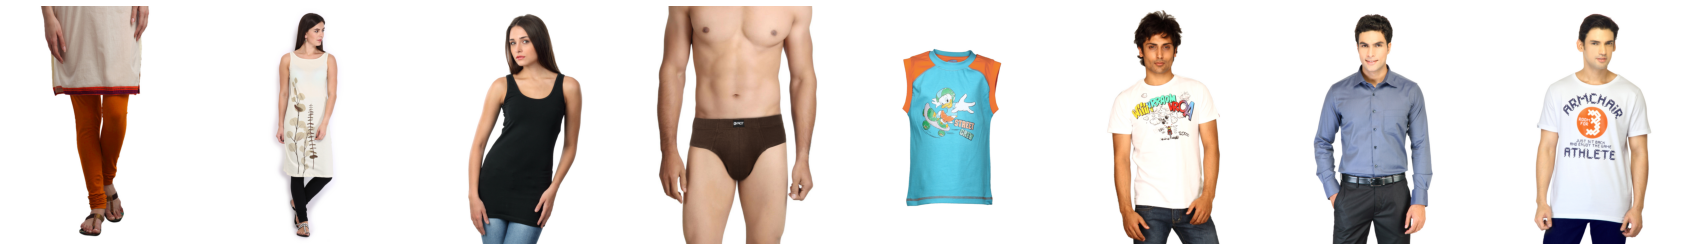

In [58]:
%matplotlib inline

w = svm_clf.coef_[0]
rand_emb = df_embs_filtered_compressed.sample()
nav_axis = compute_navigation_axis(rand_emb, w, 150)

images = explore_space(int(min(nav_axis[0])), int(max(nav_axis[0])))

fig = plt.figure(figsize=(30, 30))
columns = len(images)
rows = 1
id = 0
for i in range(1, columns*rows+1):
    img = plt.imread(get_img_path(df.loc[df['id'] == images[id]].image.values[0]))
    fig.add_subplot(rows, columns, i)
    plt.axis(False)
    plt.imshow(img)
    id = id + 1
plt.show()


In [40]:
%matplotlib widget

from ipywidgets import AppLayout, FloatSlider

# Create matplotlib figure for displaying fashion items
fig = plt.figure(figsize=(7, 7))

# Create orthogonal navigation axis
w = svm_clf.coef_[0]
rand_emb = df_embs_filtered_compressed.sample()
nav_axis = compute_navigation_axis(rand_emb, w, 10000)

starting_idx = np.where(np.isclose(nav_axis[0], min(nav_axis[0], key=lambda x:abs(x-min(nav_axis[0])))))[0][0]
user_position = initialize_user_position(nav_axis, starting_idx)

nearest_neighbour = get_nearest_neighbour(user_position, df_filtered_gender)
annotate_nearest_neighbour(nearest_neighbour, df_filtered_gender)

plt.title('Nearest Embedding: {} with season: {}'.format(nearest_neighbour, df_filtered_gender.loc[df_filtered_gender['id'] == nearest_neighbour].baseColour.values[0]))

# Create Slider to navigate in embedding space
slider = FloatSlider(
    orientation="horizontal",
    description="x-Position:",
    value=user_position[0],
    min=min(nav_axis[0]),
    max=max(nav_axis[0])
)
slider.layout.margin = '0px 10% 0px 10%'
slider.layout.width = '40%'

slider.observe(update_user_position, names='value')

display(slider)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

FloatSlider(value=-197.50643266642112, description='x-Position:', layout=Layout(margin='0px 10% 0px 10%', widt…